# Adding a regularizer

<img src="images/reg1.png">

While our loss function allows us to determine how well (or poorly) our set of parameters (i.e., weight matrix, and bias vector) are performing on a given classification task, the loss function itself does not take into account how the weight matrix “looks”. This brings us to the following queations.  How do we go about choosing a set of parameters that will help ensure our model generalizes well? Or at the very least, lessen the affects of overfitting?

The answer is <b>regularization.</b>

This notebook is divided into two parts. In the first part we will observe the behaviour of the weight space after adding adding a regularization term while in the second part, we will use some property of the learnt weight space to remove redundant connections.

Let us begin by our regular import statements.

In [0]:
import numpy as np
import torch 
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

### Hyperparameters to be used

In [0]:
num_epochs = 5
batch_size = 100
learning_rate = 0.001
use_reg = False

### Downloading the MNIST Dataset

In [0]:
train_dataset = dsets.MNIST(root='../../data/lab6',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='../../data/lab6',
                           train=False, 
                           transform=transforms.ToTensor())

### Dataloader

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

### Defining the network

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(7*7*32, 300)
        self.fc2 = nn.Linear(300, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

<b>The below function is called to reinitialize the weights of the network and define the required loss criterion and the optimizer.</b> 

In [0]:
def reset_model():
    net = Net()
    net = net.cuda()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    return net,criterion,optimizer

### L1 Regularization

Here, we define a L1 Regularizer and add it to our loss function. The L1 Regularization term basically adds a penalty, equivalent to the absolute value of the magnitude of the weights. This ensures that the magnitude of the weights do not become too high.

We have seen in the previous lectures that adding the L1 regularizer ensures sparsity. This is important becuase our ultimate aim is to prune connections from our network. That would mean we should try to make as many weights extremely close to 0 as possible. Thus, adding this penalty term ensures sparsity. The L1 Regularizer is also known as Lass Regression and it can be defined as follows:

$$P=\lambda*\sum_{i=1}^{n}|\theta_{i}-0|$$

In [0]:
def l1_regularizer(net, loss, beta):
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in net.parameters():
        target = Variable((torch.FloatTensor(param.size()).zero_()).cuda())
        reg_loss += l1_crit(param, target)
        
    loss += beta * reg_loss
    return loss

### Initializing the model

In [0]:
net, criterion, optimizer = reset_model()

### Defining the training function

In [0]:
# Train the Model

def training(net, reset = True):
    if reset == True:
        net, criterion, optimizer = reset_model()
    else:
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    net.train()
    for epoch in range(num_epochs):
        total_loss = 0
        accuracy = []
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()
            temp_labels = labels
            images = Variable(images)
            labels = Variable(labels)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)

            if use_reg == True :
                loss = l1_regularizer(net,loss,beta=0.001)

            loss.backward()
            optimizer.step()

            total_loss += loss.data[0]
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == temp_labels).sum()
            accuracy.append(correct/float(batch_size))

        print('Epoch: %d, Loss: %.4f, Accuracy: %.4f' %(epoch+1,total_loss, (sum(accuracy)/float(len(accuracy)))))
    
    return net

### Defining the testing function

In [0]:
# Test the Model
def testing(net):
    net.eval() 
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        images = Variable(images)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Test Accuracy of the network on the 10000 test images: %.2f %%' % (100.0 * correct / total))

### Training and testing the network

In [12]:
reset = True
net = training(net, reset)
testing(net)

Epoch: 1, Loss: 76.1952, Accuracy: 0.9607
Epoch: 2, Loss: 31.1691, Accuracy: 0.9838
Epoch: 3, Loss: 25.4879, Accuracy: 0.9865
Epoch: 4, Loss: 18.7592, Accuracy: 0.9900
Epoch: 5, Loss: 16.7254, Accuracy: 0.9909
Test Accuracy of the network on the 10000 test images: 98.85 %


### Function for plotting the weight distribution

We want to plot the weights learnt during training and we define the following function to do so. It is important to note that in order ro achieve smoothness in the behaviour of the plot we use 256 clusters here where the nearest weight values are rounded to. Feel free to experiment with defining lesser number of clusters for the weight distribution approximation. However, the plot may not be as smooth. 

We plot the cluster values in the x-axis and the frequency of the weights in the y-axis.

In [0]:
def weightdistribution(weights):
    maxim= np.amax(weights)
    print("Maximum value of learnt weights: " + str(maxim))
    
    minim= np.amin(weights)
    print("Minimum value of learnt weights: " + str(minim))
    
    step= (maxim-minim)/255
    freq= np.zeros(256)
    steps=[]

    for i in range(0,256):
        steps.append(minim)
        minim+=step
    
    m = weights.shape[0]
    
    for i in range(0,m):
        e= weights[i]
        dist= (steps-e)**2
        freq[np.argmin(dist)]+=1
    
        
    plt.plot(steps,list(freq))
    plt.show()

In [0]:
weightdistribution(net.state_dict()['layer2.0.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc1.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc2.weight'].cpu().numpy().flatten())

### Defining the pruning function

We use a threshold based criteria to remove certain connections in the networks which fall within a threshold value. Hence, we define a function which takes the network as input and a vlaue for threshold and forces those connections to be 0 which fall with the threshold given by the following equation.

$$
\begin{equation}
 W_{i} = 
 \begin{cases} 
      W_{i} & W_{i} < -\theta \\
      0 & -\theta\leq W_{i}\leq \theta \\
      W_{i} & \theta < W_{i} 
  \end{cases}
\end{equation}
$$

We prune both the weights and biases of Convolution layers, Fully Connected layers and the Batch Normalization layers

In [0]:
def prune_weight(net, threshold):
    
    for m in net.modules():
        if isinstance(m,nn.Conv2d) or isinstance(m,nn.BatchNorm2d) or isinstance(m,nn.Linear):

            temp_weight = m.weight.data.cpu().numpy()
            dims = temp_weight.shape
            print('WEIGHT ',dims)
            print("Before pruning------->")
            print(np.count_nonzero(temp_weight))

            temp_weight = temp_weight.flatten()

            [x1,x2]=((np.where(np.all([[(-1*threshold) < (temp_weight)] , [(temp_weight) < threshold]],axis=0))))
            temp_weight[x2] = 0
            temp_weight = np.reshape(temp_weight,dims)
            print("After pruning------->")
            print(np.count_nonzero(temp_weight))
            print('-------------------------------------------------------------------------------')
            m.weight.data = (torch.FloatTensor(temp_weight).cuda())

            temp_bias = m.bias.data.cpu().numpy()
            dims = temp_bias.shape
            print('BIAS ',dims)
            print("Before pruning------->")
            print(np.count_nonzero(temp_bias))

            temp_bias = temp_bias.flatten()

            [x1,x2]=((np.where(np.all([[(-1*threshold) < (temp_bias)] , [(temp_bias) < threshold]],axis=0))))
            temp_bias[x2] = 0
            temp_bias = np.reshape(temp_bias,dims)
            print("After pruning------->")
            print(np.count_nonzero(temp_bias))
            print('-------------------------------------------------------------------------------')
            m.bias.data = (torch.FloatTensor(temp_bias).cuda())

# for m in net.modules():
#     if isinstance(m,nn.Conv2d):
#         print m.bias.data
  

Here, we check how many connetions have been pruned

In [0]:
threshold = 0.01
prune_weight(net,threshold)

('WEIGHT ', (16, 1, 5, 5))
Before pruning------->
400
After pruning------->
388
-------------------------------------------------------------------------------
('BIAS ', (16,))
Before pruning------->
16
After pruning------->
15
-------------------------------------------------------------------------------
('WEIGHT ', (16,))
Before pruning------->
16
After pruning------->
16
-------------------------------------------------------------------------------
('BIAS ', (16,))
Before pruning------->
16
After pruning------->
15
-------------------------------------------------------------------------------
('WEIGHT ', (16, 16, 3, 3))
Before pruning------->
2304
After pruning------->
2082
-------------------------------------------------------------------------------
('BIAS ', (16,))
Before pruning------->
16
After pruning------->
13
-------------------------------------------------------------------------------
('WEIGHT ', (16,))
Before pruning------->
16
After pruning------->
16
-------------

Training the network again using the regularizer. The loss is modified as 

$$
loss = loss + regularized_loss
$$

In [0]:
reset = True
use_reg = True
net = training(net, reset)
testing(net)

Epoch: 1, Loss: 578.7805, Accuracy: 0.9518
Epoch: 2, Loss: 240.8670, Accuracy: 0.9754
Epoch: 3, Loss: 194.5346, Accuracy: 0.9795
Epoch: 4, Loss: 177.1534, Accuracy: 0.9803
Epoch: 5, Loss: 167.5613, Accuracy: 0.9804
Test Accuracy of the network on the 10000 test images: 98.39 %


<b>Visualizing the weight distributions with the regularized loss</b>

Maximum value of learnt weights: 0.0922381
Minimum value of learnt weights: -0.157906


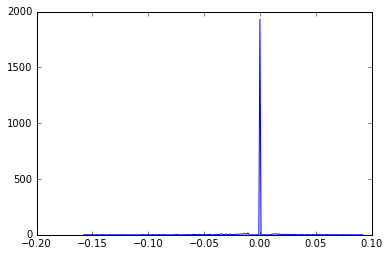

Maximum value of learnt weights: 0.412582
Minimum value of learnt weights: -0.364495


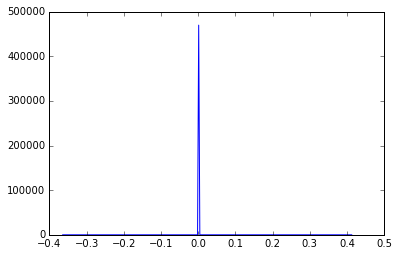

Maximum value of learnt weights: 0.628237
Minimum value of learnt weights: -0.628519


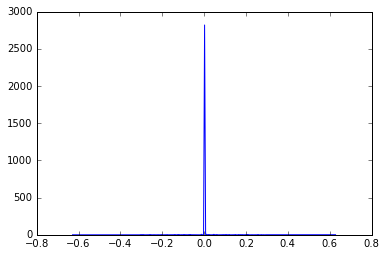

In [0]:
weightdistribution(net.state_dict()['layer2.0.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc1.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc2.weight'].cpu().numpy().flatten())

By using the L1 Regularizer, we see that we have forced the network to learn weights within a constrained subspace. Since more number of weights are closer to 0, it is evident that we will be able to make more weights 0 by using the same threshold as before. This, therefore ensures sparsity in every layer of the network.

An interesting observation is that the netowrk tells us that it does not require biases for certain layers.

In [0]:
threshold = 0.01
prune_weight(net,threshold)

('WEIGHT ', (16, 1, 5, 5))
Before pruning------->
400
After pruning------->
165
-------------------------------------------------------------------------------
('BIAS ', (16,))
Before pruning------->
16
After pruning------->
0
-------------------------------------------------------------------------------
('WEIGHT ', (16,))
Before pruning------->
16
After pruning------->
12
-------------------------------------------------------------------------------
('BIAS ', (16,))
Before pruning------->
16
After pruning------->
7
-------------------------------------------------------------------------------
('WEIGHT ', (16, 16, 3, 3))
Before pruning------->
2304
After pruning------->
373
-------------------------------------------------------------------------------
('BIAS ', (16,))
Before pruning------->
16
After pruning------->
0
-------------------------------------------------------------------------------
('WEIGHT ', (16,))
Before pruning------->
16
After pruning------->
13
-----------------

### References

1. http://www.pyimagesearch.com/2016/09/19/understanding-regularization-for-image-classification-and-machine-learning/